In [1]:
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import KFold
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

from IPython.display import clear_output

import json

In [2]:
MODEL_FILE = "3.5. Esembler_RandomForest_PA_CC.json"

In [3]:
# Random Forest
TREE_PARAMS = {
    "random_state" : 0,
    "max_depth": 7,
    "n_jobs" : -1
}

In [4]:
path1 = Path(r"A:\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")
path2 = Path(r"C:\Users\rober\Documents\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")

if path1.is_dir():
    DATASET_DIR = path1
else:
    DATASET_DIR = path2

In [5]:
# Check if Models exists

In [6]:
model_path = DATASET_DIR / "Models" / MODEL_FILE
MODEL_EXIST = model_path.is_file()

In [7]:
# Daten

In [8]:
app_train = pd.read_csv(DATASET_DIR / "4. FillNA" / "application.csv")
pa_cc = pd.read_csv(DATASET_DIR / "4. FillNA" / "pa_cc.csv")
app_train = app_train.set_index("SK_ID_CURR")
pa_cc = pa_cc.set_index("SK_ID_CURR")

In [9]:
pa_cc.head()

,PA_CNT_CREDITS,PA_CC_BALANCE_30,PA_CC_PAYMENT_30,PA_CC_DPD_30,PA_CC_BALANCE_60,PA_CC_PAYMENT_60,PA_CC_DPD_60,PA_CC_BALANCE_90,PA_CC_PAYMENT_90,PA_CC_DPD_90,PA_CC_BALANCE_120,PA_CC_PAYMENT_120,PA_CC_DPD_120,PA_CC_BALANCE_150,PA_CC_PAYMENT_150,PA_CC_DPD_150,PA_CC_BALANCE_180,PA_CC_PAYMENT_180,PA_CC_DPD_180,PA_AMT_ANNUITY,PA_AMT_APPLICATION,PA_AMT_CREDIT,PA_AMT_GOODS_PRICE,PA_CNT_NAME_CONTRACT_TYPE_Revolving loans,PA_CNT_NAME_CONTRACT_STATUS_Refused,PA_CNT_CODE_REJECT_REASON_HC,PA_CNT_NAME_CLIENT_TYPE_New,PA_CNT_NAME_CLIENT_TYPE_Refreshed,PA_CNT_NAME_PORTFOLIO_Cards,PA_CNT_NAME_PRODUCT_TYPE_walk-in,PA_CNT_NAME_YIELD_GROUP_high,PA_CNT_NAME_YIELD_GROUP_low_normal,PA_CNT_PRODUCT_COMBINATION_Card Street,PA_CNT_PRODUCT_COMBINATION_Cash X-Sell: low,PA_CNT_PRODUCT_COMBINATION_POS industry with interest
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
394447,1.0,-1.206367,-1.389108,0.0,1.434002,1.008387,0.0,0.992963,-0.429381,0.0,-0.349513,-0.292196,0.0,-0.415697,-0.215746,0.0,-0.455389,1.318045,0.0,2250.0,45000.0,45000.0,45000.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
361282,1.0,0.946004,0.850318,0.0,0.828945,1.109609,0.0,0.861611,0.179508,0.0,-0.393110,-1.267179,0.0,-1.074370,0.280581,0.0,-1.169080,-1.152838,0.0,2250.0,45000.0,45000.0,45000.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
436351,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2250.0,45000.0,45000.0,45000.0,1.0,3.0,3.0,0.0,1.0,1.0,1.0,2.0,6.0,1.0,3.0,0.0
181153,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2250.0,45000.0,45000.0,45000.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0
309691,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2250.0,45000.0,45000.0,45000.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [10]:
# Ermittlung Reihenfolge

In [11]:
y = app_train.loc[pa_cc.index]["TARGET"]
x = pa_cc

In [12]:
if not MODEL_EXIST:
    # unterteilt den trainingsdatensatz in trainings- und validierungsdatensätze
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, random_state=0)

    # logistisches Regressionsmodell
    model = RandomForestClassifier(**TREE_PARAMS)
    model.fit(x_train, y_train)

    auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    print(auc)

    # Koeffizienten der einzelnen Klassen
    coef_dict = {}
    for coef, feat in zip(model.feature_importances_, x.columns.values):
        coef_dict[feat] = coef

    # Feature Importance
    d = dict(sorted(coef_dict.items(), key=lambda item: item[1], reverse=True))
    order = list(d.keys())
    
    model_data = {
    "todo" : order,
    "keep" : [],
    "drop" : [],
    "params" : TREE_PARAMS,
    "auc" : [],
    "p" : [],
    "n" : []
    }
    
    auc_temp = 0.5

0.6487378691497303


In [13]:
if MODEL_EXIST:
    with open(DATASET_DIR / "Models" / MODEL_FILE, 'r') as file:
        model_data = json.load(file)
    auc_temp = model_data["auc"][-1]

In [14]:
#Entscheidungsbaum Parameterbestimmung

In [15]:
df = pa_cc

print('auc: %s, todo: %s, keep: %s, drop: %s' % (round(auc_temp,4), len(model_data["todo"]), len(model_data["keep"]), len(model_data["drop"])))
todo = model_data["todo"].copy()

for head in todo:
    
    model_data["keep"].append(head)
    
    X = df[model_data["keep"]]
    y = app_train.loc[pa_cc.index]["TARGET"]
    x = X
    
    model = RandomForestClassifier(**TREE_PARAMS).fit(x, y)
    
    aucs = []

    kfold = KFold(5, shuffle=True, random_state=1)

    for train, test in kfold.split(x):
        model.fit(x.iloc[train], y.iloc[train])
        auc = roc_auc_score(y.iloc[test], model.predict_proba(x.iloc[test])[:,1])
        aucs.append(auc)
    
    auc = np.mean(aucs)
    n = len(X)
    p = len(X.columns)
    
    if auc > auc_temp:
        
        model_data["auc"].append(auc)
        model_data["p"].append(p)
        model_data["n"].append(n)
        
        auc_temp = auc
        
    else:
        model_data["keep"].remove(head)
        model_data["drop"].append(head)
    
    model_data["todo"].remove(head)
    
    with open(DATASET_DIR / "Models" / MODEL_FILE, 'w') as file:
        json.dump(model_data, file)
        
    clear_output(wait=True)
    print('auc: %s, todo: %s, keep: %s, drop: %s' % (round(auc,4), len(model_data["todo"]), len(model_data["keep"]), len(model_data["drop"])))

auc: 0.6502, todo: 0, keep: 21, drop: 14


         auc   p      n
20  0.650898  21  77934


<AxesSubplot:>

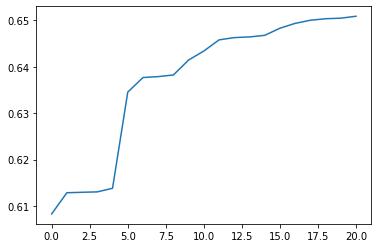

In [16]:
data = {
    "auc" : model_data["auc"],
    "p" : model_data["p"],
    "n" : model_data["n"]
}

result = pd.DataFrame(data)

print(result[result["auc"] == result["auc"].max()])
result["auc"].plot()

In [17]:
model = RandomForestClassifier(**TREE_PARAMS)

aucs = []

kfold = KFold(5, shuffle=True, random_state=1)

X = df[model_data["keep"]]
y = app_train.loc[pa_cc.index]["TARGET"]
x = X

# enumerate splits
for train, test in kfold.split(x):
    
    model.fit(x.iloc[train], y.iloc[train])
    auc = roc_auc_score(y.iloc[test], model.predict_proba(x.iloc[test])[:,1])
    aucs.append(auc)
    
    print('train: %s, test: %s, auc: %s' % (train, test, round(auc,4)))

print("\n")
print("Durchschnitt: %.4f" % (np.mean(aucs)))
print("Standardabw.: %.2f" % (np.std(aucs)))
print("Varianz:      %.2f" % (np.var(aucs)))

train: [    0     2     3 ... 77931 77932 77933], test: [    1    10    24 ... 77913 77922 77925], auc: 0.6535
train: [    0     1     2 ... 77931 77932 77933], test: [    3     8    12 ... 77927 77928 77930], auc: 0.6506
train: [    0     1     3 ... 77929 77930 77931], test: [    2    11    22 ... 77918 77932 77933], auc: 0.6498
train: [    1     2     3 ... 77930 77932 77933], test: [    0     4     6 ... 77920 77926 77931], auc: 0.6489
train: [    0     1     2 ... 77931 77932 77933], test: [    5     9    15 ... 77916 77924 77929], auc: 0.6517


Durchschnitt: 0.6509
Standardabw.: 0.00
Varianz:      0.00


In [18]:
model_data["keep"]

['PA_CC_BALANCE_60',
 'PA_CC_BALANCE_30',
 'PA_CC_BALANCE_90',
 'PA_CC_BALANCE_180',
 'PA_CC_BALANCE_120',
 'PA_CNT_NAME_PRODUCT_TYPE_walk-in',
 'PA_CC_PAYMENT_60',
 'PA_CC_PAYMENT_180',
 'PA_CC_PAYMENT_120',
 'PA_CNT_NAME_CONTRACT_STATUS_Refused',
 'PA_AMT_CREDIT',
 'PA_AMT_APPLICATION',
 'PA_AMT_GOODS_PRICE',
 'PA_CNT_CODE_REJECT_REASON_HC',
 'PA_CNT_NAME_YIELD_GROUP_high',
 'PA_CNT_NAME_CLIENT_TYPE_New',
 'PA_CNT_PRODUCT_COMBINATION_Cash X-Sell: low',
 'PA_CNT_NAME_YIELD_GROUP_low_normal',
 'PA_CNT_NAME_CLIENT_TYPE_Refreshed',
 'PA_CNT_PRODUCT_COMBINATION_POS industry with interest',
 'PA_CC_DPD_180']